# Model making

Create full data set for all states and don't exclude TN 

read cancer data set: state, county, avg_cost
income data - create income agg data by state and county


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#import graphviz
from IPython.display import SVG

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Create a DataFrame, ha_costs_df, from the mmd_heart_attack_data.csv file.
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv')
#Look at the head and tail of the DataFrame
ha_costs_df.head(-1)
ha_costs_df['state'].value_counts()
ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'}, inplace = True)
ha_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470


In [3]:
ha_costs_df.shape

(2656, 17)

In [4]:
#Create a DataFrame, cancer_costs_df, from the mmd_cancer_data.csv file.
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
#Look at the head and tail of the DataFrame
cancer_costs_df.head(-1)
cancer_costs_df['state'].value_counts()
cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'}, inplace = True)
cancer_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293


In [5]:
cancer_costs_df.shape

(3165, 17)

In [6]:
#Create a DataFrame, income_df, from the irs_county_2016.csv file.
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df.info()
income_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25536 entries, 0 to 25535
Columns: 148 entries, STATEFIPS to A11902
dtypes: int64(146), object(2)
memory usage: 28.8+ MB


,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,Alabama,1,26450,14680,9740,680,17780,...,4300,9256,70,57,0,0,2590,3685,11510,35079


In [7]:
income_df.shape

(25536, 148)

In [8]:
#Keep only the following columns:
    #['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']
income_df = income_df.loc[:, ['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 
                              'NUMDEP', 'ELDERLY','A00100', 'N02650', 'A02650', 'N02300', 'A02300']]

In [9]:
#Rename columns
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 
                     'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 
                     'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 
                     'unemployment_comp']
income_df.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AL,Alabama,1,26450,14680,9740,680,40700,5590,13000,-1679314,19140,-1657452,60,203


In [10]:
income_county_agg = income_df.groupby(['state', 'county']).sum() 
# done: revisit the code: you have to agg by state and county.

In [11]:
income_county_agg.head(1)

,,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
state,county,,,,,,,,,,,,,
AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460


In [12]:
#Be sure to also `reset_index()` so that our aggregated data is re-indexed to begin at 0. 
income_county_agg = income_county_agg.reset_index()
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460


In [13]:
#DataFrame which gives the approximate average household income for each county. 
#Calculate this as 1000*`total_inc_amt` / `return_count
income_county_agg['approx_avg_income']= 1000 * income_county_agg['total_inc_amt']/income_county_agg['return_count']
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68543.715345


In [14]:
income_county_agg['county'].nunique()

1926

Merge heart attack and cancer data sets

In [15]:
cancer_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293


In [16]:
ha_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470


In [43]:
ha_cancer_costs_df = pd.merge(cancer_costs_df.loc[:,['state', 'county','primary_sex', 'primary_age', 'urban', 'cancer_avg_cost']], 
                                     ha_costs_df.loc[:,['state', 'county', 'ha_avg_cost']], on=['state', 'county'], how='inner')
ha_cancer_costs_df.head(-1)

,state,county,primary_sex,primary_age,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,All,All,Urban,19293,40470
1,ALABAMA,Baldwin County,All,All,Rural,17151,36615
2,ALABAMA,Barbour County,All,All,Rural,19469,46509
3,ALABAMA,Bibb County,All,All,Urban,17234,42949
4,ALABAMA,Blount County,All,All,Urban,20317,50067
...,...,...,...,...,...,...,...
2650,PUERTO RICO,Guaynabo Municipio,All,All,Urban,10485,25049
2651,PUERTO RICO,Mayaguez Municipio,All,All,Urban,11440,28128
2652,PUERTO RICO,Ponce Municipio,All,All,Urban,10827,26403
2653,PUERTO RICO,San German Municipio,All,All,Urban,14660,26398


In [18]:
ha_cancer_costs_df.shape

(2656, 7)

In [19]:
ha_cancer_costs_df['state'].nunique()

52

In [20]:
##Create `state_dict`, a dictionary that uses the provides descripton of state abbreviation
#import state abbreviation dataset
state_abb_df = pd.read_csv('../data/state_abbrev.csv')
state_abb_df.head(1)

,name,abbrev
0,ALABAMA,AL


In [21]:
ha_cancer_costs_df.head()

,state,county,primary_sex,primary_age,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,All,All,Urban,19293,40470
1,ALABAMA,Baldwin County,All,All,Rural,17151,36615
2,ALABAMA,Barbour County,All,All,Rural,19469,46509
3,ALABAMA,Bibb County,All,All,Urban,17234,42949
4,ALABAMA,Blount County,All,All,Urban,20317,50067


In [22]:
ha_cancer_costs_df['state']=ha_cancer_costs_df.state.map(state_abb_df.set_index('name')['abbrev'].to_dict())

In [23]:
ha_cancer_costs_df.head(1)

,state,county,primary_sex,primary_age,urban,cancer_avg_cost,ha_avg_cost
0,AL,Autauga County,All,All,Urban,19293,40470


In [24]:
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68543.715345


In [25]:
ha_cancer_costs_incomeavg_df = pd.merge(ha_cancer_costs_df, 
                                        income_county_agg.loc[:,['state', 'county', 'approx_avg_income', 'agi', 'income_bucket']], on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_df.head(1)

,state,county,primary_sex,primary_age,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket
0,AL,Autauga County,All,All,Urban,19293,40470,55680.240764,1327941,36


In [26]:
ha_cancer_costs_incomeavg_df.shape

(2619, 10)

In [27]:
ha_cancer_costs_incomeavg_df['ha_cost_income_ratio'] = ha_cancer_costs_incomeavg_df.ha_avg_cost / ha_cancer_costs_incomeavg_df.approx_avg_income
ha_cancer_costs_incomeavg_df['cancer_cost_income_ratio'] = ha_cancer_costs_incomeavg_df.cancer_avg_cost / ha_cancer_costs_incomeavg_df.approx_avg_income
ha_cancer_costs_incomeavg_df.head(1)

,state,county,primary_sex,primary_age,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,ha_cost_income_ratio,cancer_cost_income_ratio
0,AL,Autauga County,All,All,Urban,19293,40470,55680.240764,1327941,36,0.726829,0.346496


In [28]:
ha_cancer_costs_incomeavg_df.cancer_cost_income_ratio.describe()

count    2619.000000
mean        0.408461
std         0.110452
min         0.065936
25%         0.334745
50%         0.403631
75%         0.473955
max         0.989443
Name: cancer_cost_income_ratio, dtype: float64

In [29]:
ha_cancer_costs_incomeavg_df.cancer_cost_income_ratio.mean()

0.4084611666659806

In [30]:
ha_cancer_costs_incomeavg_df['condition'] = ha_cancer_costs_incomeavg_df.cancer_cost_income_ratio.mean()
ha_cancer_costs_incomeavg_df.head(1)

,state,county,primary_sex,primary_age,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,ha_cost_income_ratio,cancer_cost_income_ratio,condition
0,AL,Autauga County,All,All,Urban,19293,40470,55680.240764,1327941,36,0.726829,0.346496,0.408461


In [44]:
#creating depedendent variable
#average cost for cancer care is above the average cost or equal to or below the average cost
ha_cancer_costs_incomeavg_df['cancer_cost_income_ratio_above_avg_y'] = ha_cancer_costs_incomeavg_df.cancer_cost_income_ratio > ha_cancer_costs_incomeavg_df.condition
ha_cancer_costs_incomeavg_df.head(-1)

,state,county,primary_sex,primary_age,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,urban_Urban
0,AL,Autauga County,All,All,19293,40470,55680.240764,1327941,36,0.726829,0.346496,0.408461,False,1
1,AL,Baldwin County,All,All,17151,36615,62603.044838,5908443,36,0.584876,0.273964,0.408461,False,0
2,AL,Barbour County,All,All,19469,46509,40094.136808,364774,36,1.159995,0.485582,0.408461,True,0
3,AL,Bibb County,All,All,17234,42949,47260.201511,371500,36,0.908777,0.364662,0.408461,False,1
4,AL,Blount County,All,All,20317,50067,49333.197648,1078297,36,1.014874,0.411832,0.408461,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,WY,Platte County,All,All,23937,47718,52024.401914,213967,36,0.917223,0.460111,0.408461,True,0
2614,WY,Sheridan County,All,All,19864,59314,68287.817938,999357,36,0.868588,0.290886,0.408461,False,0
2615,WY,Sweetwater County,All,All,23139,57980,67995.656617,1319648,36,0.852702,0.340301,0.408461,False,0
2616,WY,Teton County,All,All,14149,31371,214588.045007,2999067,36,0.146192,0.065936,0.408461,False,0


In [32]:
#get dummmies
ha_cancer_costs_incomeavg_df = pd.get_dummies(ha_cancer_costs_incomeavg_df, columns = ['urban'], drop_first = True)

In [33]:
ha_cancer_costs_incomeavg_df.head(1)

,state,county,primary_sex,primary_age,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,urban_Urban
0,AL,Autauga County,All,All,19293,40470,55680.240764,1327941,36,0.726829,0.346496,0.408461,False,1


In [34]:
#log reg model
X = ha_cancer_costs_incomeavg_df[['urban_Urban']]
y = ha_cancer_costs_incomeavg_df['cancer_cost_income_ratio_above_avg_y']

In [35]:
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

LogisticRegression()

In [38]:
logistic_model.coef_[0]

array([-1.4461537])

In [40]:
#machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [41]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

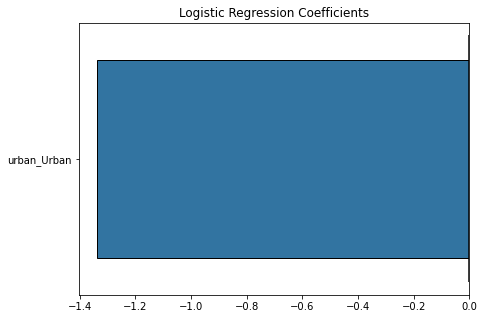

In [42]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')

ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

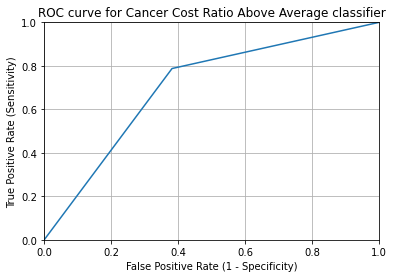

In [144]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Ratio Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [145]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.7029370629370629


Build and evaluate a `RandomForestClassifier`

In [150]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [151]:
y_pred_train = tree.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.6471486761710794


In [152]:
y_pred = tree.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.7022900763358778


In [146]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=1000)

In [147]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.6471486761710794


In [148]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7022900763358778


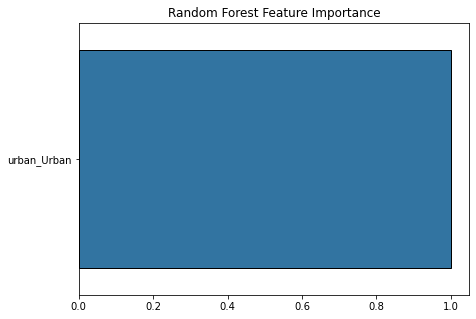

In [149]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance');